## TCC CBB

Desenvolvido por Ricardo e Thyago.

#### Objetivo: 

Este é uma das primeiras avaliações feitas com a utilização do PCA, SVM e MLP. Este código, possui duas avaliações exaustivas para as técnicas. A primeira avaliação, consiste na análise de componentes, com esta análise é possível identificar os componentes que, possuem as melhores assertividades. A segunda avaliação, é a de teste/treino, aplica-se o K-fold variando de [0.1 1.0], para os conjuntos de componentes. Toda a aplicação é feita sobre a base de dados de doenças cardio vasculares.


### importando bibliotecas

In [1]:
import random
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import time
import datetime

In [2]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#C:\Users\Thyago M\Desktop\MOLIC
plt.rcParams['animation.ffmpeg_path'] = 'C:\\Users\\Thyago M\\Desktop\\ffmpeg.exe'

## Importando Base de Dados de Doenças cardio vasculares

In [4]:
def converte_binario(palavra):
    if palavra=='Yes' or palavra==True:
        return 0
    elif palavra=='No' or palavra==False:
        return 1

In [5]:
def descarregaBaseCardio():    
    df_cardio = pd.read_csv(os.getcwd()+'\\cardio_train.csv',sep=";")
    df_cardio_target = df_cardio['cardio']
    df_cardio.drop('cardio', axis=1, inplace=True)
    df_cardio.drop('id', axis=1, inplace=True)
    
    return df_cardio, df_cardio_target

## K-FOLD

#### K - Fold para a avaliação exaustiva baseado no número de componentes

In [6]:
def aplicaKFold(x_pca, df_cardio_target):
    divisao = 0.2
    X_train, X_test, y_train, y_test = train_test_split(x_pca, df_cardio_target, test_size=divisao)
   
    return (X_train, X_test, y_train, y_test)

#### K-fold para a avaliaçao exaustiva Treino/Teste da base de dados

In [7]:
def aplicaKFoldAlterado(x_pca, df_cardio_target, divisao):
    X_train, X_test, y_train, y_test = train_test_split(x_pca, df_cardio_target, test_size=divisao)
    return (X_train, X_test, y_train, y_test)

## Import dos Classificadores

### MLP

In [8]:
from sklearn import linear_model, model_selection, metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [9]:
def aplicaMLP(X_train, X_test, y_train):
    
    modelMLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=0)

    modelMLP.fit(X_train, y_train)
    predictionsMLP = modelMLP.predict_proba(X_test)
    
    return predictionsMLP

### SVM

In [10]:
from sklearn.svm import SVC

In [11]:
def aplicaSVM(X_train, X_test, y_train): 

    model_svm = SVC(probability = True, kernel = 'rbf')

    model_svm.fit(X_train, y_train)

    predictionsSVM = model_svm.predict_proba(X_test)

    return predictionsSVM

# SCALED DATA PADRÃO

In [12]:
df_cardio, df_cardio_target = descarregaBaseCardio()
scaler = StandardScaler()
scaler.fit(df_cardio)
scaled_data_alt= scaler.transform(df_cardio)

In [13]:
df_cardio.shape

(70000, 11)

## APLICAÇÕES COM O MLP

### Avaliaçao com base no número de componentes

In [14]:
convergencia = False
auc_total = []
auc_num_componentes = []
media_anterior = 0

tempo = datetime.datetime.now() 
ini = time.time()

for numComponentes in range(1, 12):
    auc_componente = []
    media_anterior = 0
    qtd_iguais = 0
    pca_MLP1 = PCA(n_components = numComponentes)
    pca_MLP1.fit(scaled_data_alt)
    
    x_pca = pca_MLP1.transform(scaled_data_alt)
    
    convergencia = False
    
    print("Componente", numComponentes)
    
    while(not convergencia):
        X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = aplicaKFold(x_pca, df_cardio_target)
        predictedprob = aplicaMLP(X_train_mlp, X_test_mlp, y_train_mlp)
        
        fpr, tpr, thresholds = roc_curve(y_test_mlp, predictedprob[:,1])
        roc_auc = auc(fpr, tpr)
        auc_componente.append(roc_auc)
        media_aucs = round(sum(auc_componente) / len(auc_componente), 2)
           
        if media_anterior == media_aucs:
            qtd_iguais = qtd_iguais + 1
        if qtd_iguais == 10:
            auc_num_componentes.append(media_aucs)
            auc_total.append(auc_componente)
            convergencia = True
         
        media_anterior = media_aucs
        
fim = time.time()
tempo2 = datetime.datetime.now() 

print("TEMPO", fim-ini)  
retorno_tempo = tempo2-tempo
print(retorno_tempo)


Componente 1
Componente 2
Componente 3
Componente 4
Componente 5
Componente 6
Componente 7
Componente 8
Componente 9
Componente 10
Componente 11
TEMPO 216.13646340370178
0:03:36.136464


### Gráfico de assertividade com base nos componentes

In [15]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

df = pd.DataFrame()
df['Media'] = auc_num_componentes
df['Num Componentes'] = np.arange(1, 12)

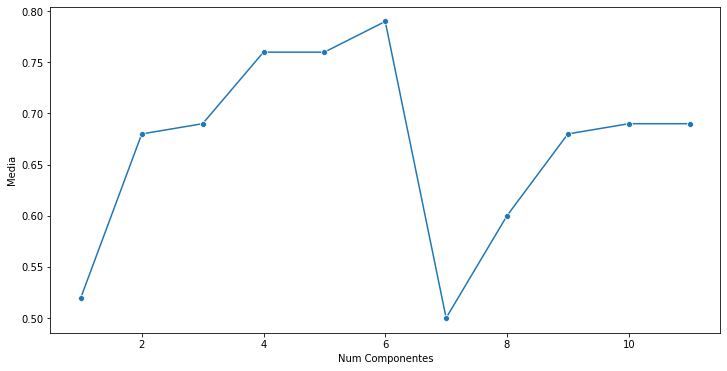

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))  
g = sns.lineplot(y='Media', x = 'Num Componentes', data=df, marker = 'o')
xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
plt.savefig('media_pca_componentes_MLP-wa.png')

#### CURVA ROC - MLP

In [18]:
divisao = 0.2
pca_mlp = PCA(n_components = 6)
pca_mlp.fit(scaled_data_alt)
x_pca = pca_mlp.transform(scaled_data_alt)

X_train, X_test, y_train, y_test = aplicaKFoldAlterado(x_pca, df_cardio_target, divisao)
predictedprob = aplicaMLP(X_train, X_test, y_train)

fpr, tpr, thresholds = roc_curve(y_test, predictedprob[:,1])
roc_auc= auc(fpr, tpr)

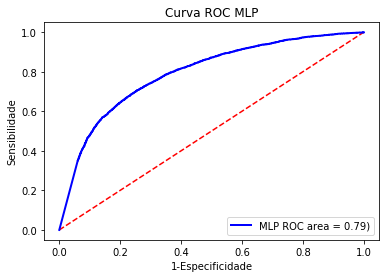

In [19]:
fig = plt.figure()
plt.xlabel('1-Especificidade')
plt.ylabel('Sensibilidade')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Curva ROC MLP')
plt.plot(fpr, tpr, color='blue', lw=2, label='MLP ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.rcParams.update({'font.size': 10})
plt.show()
fig.savefig('ROC_MLP-V1-base-wa.PNG')

#plt.rcParams.update({'font.size': 20})

## Avaliação Exaustiva - Teste/Treino - MLP

In [35]:
convergencia = False
auc_total = []
auc_num_componentes = []
media_anterior = 0
auc_divisao = []
numAucsComponentes = []
numAucsDivisao = []
tempo = datetime.datetime.now() 
ini = time.time()

for divisao in np.arange(0.1, 1, 0.1):
    print("DIVISAO DA BASE DE DADOS0", divisao)

    for numComponentes in range(1, 12):
        #print(numComponentes)
        
        auc_componente = []
        media_anterior = 0
        qtd_iguais = 0
        pca_MLP = PCA(n_components = numComponentes)
        pca_MLP.fit(scaled_data_alt)
        x_pca_MLP = pca_MLP.transform(scaled_data_alt)
        
        convergencia = False
        print("COMPONENTE", numComponentes)
    
        while(not convergencia):
            
            X_train, X_test, y_train, y_test = aplicaKFoldAlterado(x_pca_MLP, df_cardio_target, divisao)
            predictedprob = aplicaMLP(X_train, X_test, y_train)
           
            fpr, tpr, thresholds = roc_curve(y_test, predictedprob[:,1])
            roc_auc = auc(fpr, tpr)
            
            auc_componente.append(roc_auc)#FEITO
            media_aucs = round(sum(auc_componente) / len(auc_componente), 2)#feito
           
            if media_anterior == media_aucs:
                qtd_iguais = qtd_iguais + 1
                
            if qtd_iguais == 10:
                numAucsComponentes.append(len(auc_componente))
                auc_total.append(media_aucs)
                convergencia = True  

            media_anterior = media_aucs      
            
            print("Media Anterior", media_anterior)
            print("QUANTIDADE", qtd_iguais)
            
    numAucsDivisao.append(numAucsComponentes)
    auc_divisao.append(auc_total)
    numAucsComponentes = []
    auc_total = []   
    
fim = time.time()
tempo2 = datetime.datetime.now() 

print("TEMPO", fim-ini)  
retorno_tempo = tempo2-tempo
print(retorno_tempo)

DIVISAO DA BASE DE DADOS0++++++++++++++++++++++++++++++ 0.1
COMPONENTE++++++++++++++++++++++++++++++++++++++ 1
Media Anterior 0.79
QUANTIDADE 0
Media Anterior 0.79
QUANTIDADE 1
Media Anterior 0.79
QUANTIDADE 2
Media Anterior 0.79
QUANTIDADE 3
Media Anterior 0.79
QUANTIDADE 4
Media Anterior 0.79
QUANTIDADE 5
Media Anterior 0.79
QUANTIDADE 6
Media Anterior 0.78
QUANTIDADE 6
Media Anterior 0.78
QUANTIDADE 7
Media Anterior 0.78
QUANTIDADE 8
Media Anterior 0.79
QUANTIDADE 8
Media Anterior 0.79
QUANTIDADE 9
Media Anterior 0.79
QUANTIDADE 10
COMPONENTE++++++++++++++++++++++++++++++++++++++ 2
Media Anterior 0.68
QUANTIDADE 0
Media Anterior 0.73
QUANTIDADE 0
Media Anterior 0.66
QUANTIDADE 0
Media Anterior 0.64
QUANTIDADE 0
Media Anterior 0.63
QUANTIDADE 0
Media Anterior 0.61
QUANTIDADE 0
Media Anterior 0.59
QUANTIDADE 0
Media Anterior 0.57
QUANTIDADE 0
Media Anterior 0.59
QUANTIDADE 0
Media Anterior 0.58
QUANTIDADE 0
Media Anterior 0.59
QUANTIDADE 0
Media Anterior 0.58
QUANTIDADE 0
Media Anteri

Media Anterior 0.8
QUANTIDADE 4
Media Anterior 0.8
QUANTIDADE 5
Media Anterior 0.8
QUANTIDADE 6
Media Anterior 0.8
QUANTIDADE 7
Media Anterior 0.8
QUANTIDADE 8
Media Anterior 0.8
QUANTIDADE 9
Media Anterior 0.8
QUANTIDADE 10
COMPONENTE++++++++++++++++++++++++++++++++++++++ 4
Media Anterior 0.8
QUANTIDADE 0
Media Anterior 0.8
QUANTIDADE 1
Media Anterior 0.8
QUANTIDADE 2
Media Anterior 0.78
QUANTIDADE 2
Media Anterior 0.79
QUANTIDADE 2
Media Anterior 0.79
QUANTIDADE 3
Media Anterior 0.79
QUANTIDADE 4
Media Anterior 0.79
QUANTIDADE 5
Media Anterior 0.79
QUANTIDADE 6
Media Anterior 0.79
QUANTIDADE 7
Media Anterior 0.79
QUANTIDADE 8
Media Anterior 0.79
QUANTIDADE 9
Media Anterior 0.79
QUANTIDADE 10
COMPONENTE++++++++++++++++++++++++++++++++++++++ 5
Media Anterior 0.83
QUANTIDADE 0
Media Anterior 0.8
QUANTIDADE 0
Media Anterior 0.79
QUANTIDADE 0
Media Anterior 0.79
QUANTIDADE 1
Media Anterior 0.79
QUANTIDADE 2
Media Anterior 0.79
QUANTIDADE 3
Media Anterior 0.79
QUANTIDADE 4
Media Anterior 0

Media Anterior 0.81
QUANTIDADE 4
Media Anterior 0.81
QUANTIDADE 5
Media Anterior 0.81
QUANTIDADE 6
Media Anterior 0.81
QUANTIDADE 7
Media Anterior 0.81
QUANTIDADE 8
Media Anterior 0.81
QUANTIDADE 9
Media Anterior 0.81
QUANTIDADE 10
COMPONENTE++++++++++++++++++++++++++++++++++++++ 8
Media Anterior 0.82
QUANTIDADE 0
Media Anterior 0.83
QUANTIDADE 0
Media Anterior 0.82
QUANTIDADE 0
Media Anterior 0.82
QUANTIDADE 1
Media Anterior 0.82
QUANTIDADE 2
Media Anterior 0.82
QUANTIDADE 3
Media Anterior 0.82
QUANTIDADE 4
Media Anterior 0.82
QUANTIDADE 5
Media Anterior 0.81
QUANTIDADE 5
Media Anterior 0.81
QUANTIDADE 6
Media Anterior 0.81
QUANTIDADE 7
Media Anterior 0.81
QUANTIDADE 8
Media Anterior 0.81
QUANTIDADE 9
Media Anterior 0.81
QUANTIDADE 10
COMPONENTE++++++++++++++++++++++++++++++++++++++ 9
Media Anterior 0.82
QUANTIDADE 0
Media Anterior 0.82
QUANTIDADE 1
Media Anterior 0.82
QUANTIDADE 2
Media Anterior 0.82
QUANTIDADE 3
Media Anterior 0.82
QUANTIDADE 4
Media Anterior 0.82
QUANTIDADE 5
Media

Media Anterior 0.79
QUANTIDADE 0
Media Anterior 0.79
QUANTIDADE 1
Media Anterior 0.79
QUANTIDADE 2
Media Anterior 0.78
QUANTIDADE 2
Media Anterior 0.78
QUANTIDADE 3
Media Anterior 0.78
QUANTIDADE 4
Media Anterior 0.78
QUANTIDADE 5
Media Anterior 0.78
QUANTIDADE 6
Media Anterior 0.79
QUANTIDADE 6
Media Anterior 0.78
QUANTIDADE 6
Media Anterior 0.78
QUANTIDADE 7
Media Anterior 0.79
QUANTIDADE 7
Media Anterior 0.79
QUANTIDADE 8
Media Anterior 0.79
QUANTIDADE 9
Media Anterior 0.79
QUANTIDADE 10
COMPONENTE++++++++++++++++++++++++++++++++++++++ 2
Media Anterior 0.57
QUANTIDADE 0
Media Anterior 0.54
QUANTIDADE 0
Media Anterior 0.62
QUANTIDADE 0
Media Anterior 0.63
QUANTIDADE 0
Media Anterior 0.61
QUANTIDADE 0
Media Anterior 0.63
QUANTIDADE 0
Media Anterior 0.61
QUANTIDADE 0
Media Anterior 0.63
QUANTIDADE 0
Media Anterior 0.64
QUANTIDADE 0
Media Anterior 0.66
QUANTIDADE 0
Media Anterior 0.65
QUANTIDADE 0
Media Anterior 0.65
QUANTIDADE 1
Media Anterior 0.63
QUANTIDADE 1
Media Anterior 0.62
QUAN

Media Anterior 0.8
QUANTIDADE 0
Media Anterior 0.8
QUANTIDADE 1
Media Anterior 0.8
QUANTIDADE 2
Media Anterior 0.8
QUANTIDADE 3
Media Anterior 0.79
QUANTIDADE 3
Media Anterior 0.79
QUANTIDADE 4
Media Anterior 0.79
QUANTIDADE 5
Media Anterior 0.79
QUANTIDADE 6
Media Anterior 0.79
QUANTIDADE 7
Media Anterior 0.79
QUANTIDADE 8
Media Anterior 0.79
QUANTIDADE 9
Media Anterior 0.79
QUANTIDADE 10
COMPONENTE++++++++++++++++++++++++++++++++++++++ 5
Media Anterior 0.78
QUANTIDADE 0
Media Anterior 0.69
QUANTIDADE 0
Media Anterior 0.68
QUANTIDADE 0
Media Anterior 0.71
QUANTIDADE 0
Media Anterior 0.73
QUANTIDADE 0
Media Anterior 0.72
QUANTIDADE 0
Media Anterior 0.73
QUANTIDADE 0
Media Anterior 0.73
QUANTIDADE 1
Media Anterior 0.74
QUANTIDADE 1
Media Anterior 0.75
QUANTIDADE 1
Media Anterior 0.75
QUANTIDADE 2
Media Anterior 0.74
QUANTIDADE 2
Media Anterior 0.75
QUANTIDADE 2
Media Anterior 0.75
QUANTIDADE 3
Media Anterior 0.74
QUANTIDADE 3
Media Anterior 0.74
QUANTIDADE 4
Media Anterior 0.75
QUANTIDA

Media Anterior 0.8
QUANTIDADE 10
COMPONENTE++++++++++++++++++++++++++++++++++++++ 8
Media Anterior 0.8
QUANTIDADE 0
Media Anterior 0.8
QUANTIDADE 1
Media Anterior 0.8
QUANTIDADE 2
Media Anterior 0.8
QUANTIDADE 3
Media Anterior 0.8
QUANTIDADE 4
Media Anterior 0.8
QUANTIDADE 5
Media Anterior 0.8
QUANTIDADE 6
Media Anterior 0.8
QUANTIDADE 7
Media Anterior 0.8
QUANTIDADE 8
Media Anterior 0.8
QUANTIDADE 9
Media Anterior 0.8
QUANTIDADE 10
COMPONENTE++++++++++++++++++++++++++++++++++++++ 9
Media Anterior 0.81
QUANTIDADE 0
Media Anterior 0.8
QUANTIDADE 0
Media Anterior 0.81
QUANTIDADE 0
Media Anterior 0.81
QUANTIDADE 1
Media Anterior 0.8
QUANTIDADE 1
Media Anterior 0.8
QUANTIDADE 2
Media Anterior 0.8
QUANTIDADE 3
Media Anterior 0.8
QUANTIDADE 4
Media Anterior 0.8
QUANTIDADE 5
Media Anterior 0.8
QUANTIDADE 6
Media Anterior 0.8
QUANTIDADE 7
Media Anterior 0.8
QUANTIDADE 8
Media Anterior 0.8
QUANTIDADE 9
Media Anterior 0.8
QUANTIDADE 10
COMPONENTE++++++++++++++++++++++++++++++++++++++ 10
Media An

Media Anterior 0.79
QUANTIDADE 0
Media Anterior 0.78
QUANTIDADE 0
Media Anterior 0.79
QUANTIDADE 0
Media Anterior 0.79
QUANTIDADE 1
Media Anterior 0.78
QUANTIDADE 1
Media Anterior 0.78
QUANTIDADE 2
Media Anterior 0.78
QUANTIDADE 3
Media Anterior 0.78
QUANTIDADE 4
Media Anterior 0.78
QUANTIDADE 5
Media Anterior 0.78
QUANTIDADE 6
Media Anterior 0.78
QUANTIDADE 7
Media Anterior 0.78
QUANTIDADE 8
Media Anterior 0.78
QUANTIDADE 9
Media Anterior 0.78
QUANTIDADE 10
DIVISAO DA BASE DE DADOS0++++++++++++++++++++++++++++++ 0.9
COMPONENTE++++++++++++++++++++++++++++++++++++++ 1
Media Anterior 0.78
QUANTIDADE 0
Media Anterior 0.78
QUANTIDADE 1
Media Anterior 0.78
QUANTIDADE 2
Media Anterior 0.78
QUANTIDADE 3
Media Anterior 0.78
QUANTIDADE 4
Media Anterior 0.78
QUANTIDADE 5
Media Anterior 0.78
QUANTIDADE 6
Media Anterior 0.78
QUANTIDADE 7
Media Anterior 0.78
QUANTIDADE 8
Media Anterior 0.78
QUANTIDADE 9
Media Anterior 0.78
QUANTIDADE 10
COMPONENTE++++++++++++++++++++++++++++++++++++++ 2
Media Anter

### MAPA DE CALOR MLP

In [36]:
def add(x):
    return x+1

#df_divisaodf.astype (float)

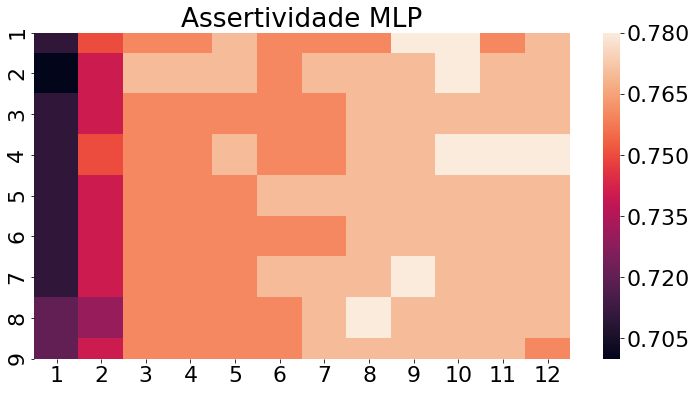

In [31]:
import seaborn as sns
fig = plt.figure(figsize = (12,6))

df_divisao = pd.DataFrame(auc_divisao)
df_divisao.set_index(np.arange(1,10), inplace = True)
df_divisao.rename(add, axis='columns', inplace=True)
sns.heatmap(data = df_divisao)
plt.title("Assertividade MLP")
plt.savefig('assertividade-MLP-divisao-numcomponente-cardio.PNG')
plt.rcParams.update({'font.size': 22})

# -------------------------------------APLICAÇÕES COM O SVM----------------------------------

### Avaliação Exaustiva - BASEADO NO NÚMERO DE COMPONENTES - SVM

In [20]:
import time
import datetime

In [ ]:
convergencia = False
auc_total = []
auc_num_componentes = []
media_anterior = 0

for numComponentes in range(1, 12):
    auc_componente = []
    media_anterior = 0
    qtd_iguais = 0
    
    pca_svm = PCA(n_components = numComponentes)
    pca_svm.fit(scaled_data_alt)
    x_pca = pca_svm.transform(scaled_data_alt)
    
    convergencia = False
    print("Componente", numComponentes)
    while(not convergencia):
        
        X_train_svm, X_test_svm, y_train_svm, y_test_svm = aplicaKFold(x_pca, df_cardio_target)
        predictedprob_svm = aplicaSVM(X_train_svm, X_test_svm, y_train_svm)
        
        fpr, tpr, thresholds = roc_curve(y_test_svm, predictedprob_svm[:,1])
        roc_auc = auc(fpr, tpr)
        auc_componente.append(roc_auc)
        
        media_aucs = round(sum(auc_componente) / len(auc_componente), 2)
    
        if media_anterior == media_aucs:
            qtd_iguais = qtd_iguais + 1
        if qtd_iguais == 10:
            auc_num_componentes.append(media_aucs)
            auc_total.append(auc_componente)
            convergencia = True
         
        media_anterior = media_aucs

Componente 1


C:\Users\Thyago M\Anaconda 3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Gráfico de assertividade com base nos componentes

In [26]:
import seaborn as sns
import numpy as np
df = pd.DataFrame()
df['Media'] = auc_num_componentes
df['Num Componentes'] = np.arange(1, 13)

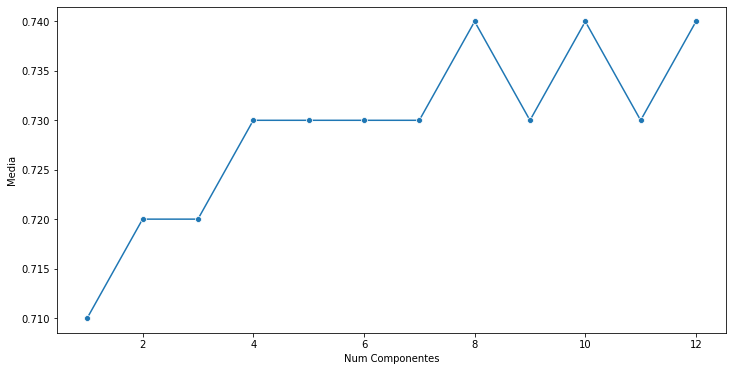

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))  
g = sns.lineplot(y='Media', x = 'Num Componentes', data=df, marker = 'o')
xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
plt.savefig('media_pca_componentes_SVM-Wa.png')

#### CURVA ROC - SVM

In [29]:
divisao = 0.2
pca_svm = PCA(n_components = 12)
pca_svm.fit(scaled_data_alt)
x_pca = pca_svm.transform(scaled_data_alt)

X_train, X_test, y_train, y_test = aplicaKFoldAlterado(x_pca, df_cardio_target, divisao)
predictedprob = aplicaSVM(X_train, X_test, y_train)

fpr, tpr, thresholds = roc_curve(y_test, predictedprob[:,1])
roc_auc= auc(fpr, tpr)

C:\Users\Thyago M\Anaconda 3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


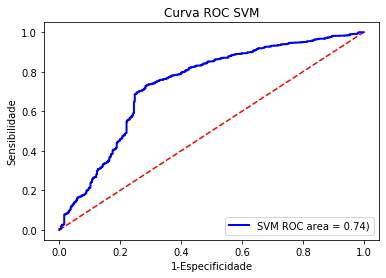

In [30]:
fig = plt.figure()
plt.xlabel('1-Especificidade')
plt.ylabel('Sensibilidade')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Curva ROC SVM')
plt.plot(fpr, tpr, color='blue', lw=2, label='SVM ROC area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.rcParams.update({'font.size': 10})
plt.show()
fig.savefig('ROC_SVM-WA.PNG')

## Avaliação Exaustiva - Teste/Treino - SVM

In [25]:
convergencia = False
auc_total = []
auc_num_componentes = []
media_anterior = 0
auc_divisao = []
numAucsComponentes = []
numAucsDivisao = []
tempo = datetime.datetime.now() 
ini = time.time()
for divisao in np.arange(0.1, 1, 0.1):
    print("DIVISAO DA BASE DE DADOS0", divisao)
    
    for numComponentes in range(1, 13):
        print(numComponentes)
        
        auc_componente = []
        media_anterior = 0
        qtd_iguais = 0
        
        pca_SVM = PCA(n_components = numComponentes)
        pca_SVM.fit(scaled_data)
        x_pca_SVM = pca_SVM.transform(scaled_data)
        
        convergencia = False
        print("COMPONENTE", numComponentes)
    
        while(not convergencia):
            
            X_train, X_test, y_train, y_test = aplicaKFoldAlterado(x_pca_SVM, df_cardio_target, divisao)
            predictedprob_smv2 = aplicaSVM(X_train, X_test, y_train)
           
            fpr, tpr, thresholds = roc_curve(y_test, predictedprob_smv2[:,1])
            roc_auc = auc(fpr, tpr)
            
            auc_componente.append(roc_auc)#FEITO
            media_aucs = round(sum(auc_componente) / len(auc_componente), 2)#feito
           
            if media_anterior == media_aucs:
                qtd_iguais = qtd_iguais + 1
                
            if qtd_iguais == 10:
                
                numAucsComponentes.append(len(auc_componente))
                auc_total.append(media_aucs)
                convergencia = True  
                
            media_anterior = media_aucs            
    numAucsDivisao.append(numAucsComponentes)
    auc_divisao.append(auc_total)
    numAucsComponentes = []
    auc_total = []   
    
fim = time.time()
tempo2 = datetime.datetime.now() 

print("TEMPO", fim-ini)  
retorno_tempo = tempo2-tempo
print(retorno_tempo)

DIVISAO DA BASE DE DADOS0++++++++++++++++++++++++++++++ 0.1
1
COMPONENTE++++++++++++++++++++++++++++++++++++++ 1
2
COMPONENTE++++++++++++++++++++++++++++++++++++++ 2
3
COMPONENTE++++++++++++++++++++++++++++++++++++++ 3
4
COMPONENTE++++++++++++++++++++++++++++++++++++++ 4
5
COMPONENTE++++++++++++++++++++++++++++++++++++++ 5
6
COMPONENTE++++++++++++++++++++++++++++++++++++++ 6
7
COMPONENTE++++++++++++++++++++++++++++++++++++++ 7
8
COMPONENTE++++++++++++++++++++++++++++++++++++++ 8
9
COMPONENTE++++++++++++++++++++++++++++++++++++++ 9
10
COMPONENTE++++++++++++++++++++++++++++++++++++++ 10
11
COMPONENTE++++++++++++++++++++++++++++++++++++++ 11
12
COMPONENTE++++++++++++++++++++++++++++++++++++++ 12
DIVISAO DA BASE DE DADOS0++++++++++++++++++++++++++++++ 0.2
1
COMPONENTE++++++++++++++++++++++++++++++++++++++ 1
2
COMPONENTE++++++++++++++++++++++++++++++++++++++ 2
3
COMPONENTE++++++++++++++++++++++++++++++++++++++ 3
4
COMPONENTE++++++++++++++++++++++++++++++++++++++ 4
5
COMPONENTE++++++++++++++

# Mapa de Calor SVM 

In [26]:
def add(x):
    return x+1

#df_divisaodf.astype (float)

In [36]:
df_divisao

,1,2,3,4,5,6,7,8,9,10,11,12
1,0.71,0.75,0.76,0.76,0.77,0.76,0.76,0.76,0.78,0.78,0.76,0.77
2,0.70,0.74,0.77,0.77,0.77,0.76,0.77,0.77,0.77,0.78,0.77,0.77
3,0.71,0.74,0.76,0.76,0.76,0.76,0.76,0.77,0.77,0.77,0.77,0.77
4,0.71,0.75,0.76,0.76,0.77,0.76,0.76,0.77,0.77,0.78,0.78,0.78
5,0.71,0.74,0.76,0.76,0.76,0.77,0.77,0.77,0.77,0.77,0.77,0.77
6,0.71,0.74,0.76,0.76,0.76,0.76,0.76,0.77,0.77,0.77,0.77,0.77
7,0.71,0.74,0.76,0.76,0.76,0.77,0.77,0.77,0.78,0.77,0.77,0.77
8,0.72,0.73,0.76,0.76,0.76,0.76,0.77,0.78,0.77,0.77,0.77,0.77
9,0.72,0.74,0.76,0.76,0.76,0.76,0.77,0.77,0.77,0.77,0.77,0.76


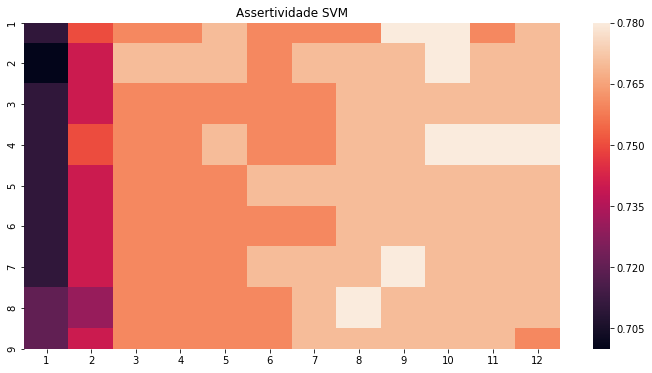

In [27]:
import seaborn as sns
fig = plt.figure(figsize = (12,6))

df_divisao = pd.DataFrame(auc_divisao)
df_divisao.set_index(np.arange(1,10), inplace = True)
df_divisao.rename(add, axis='columns', inplace=True)
sns.heatmap(data = df_divisao)
plt.title("Assertividade SVM")
plt.savefig('assertividade-SVM-divisao-numcomponente-cardio.PNG')
plt.rcParams.update({'font.size': 22})